In [1]:
from scipy.optimize import minimize
import numpy as np
import math
import numpy as np
import matplotlib.pyplot as plt


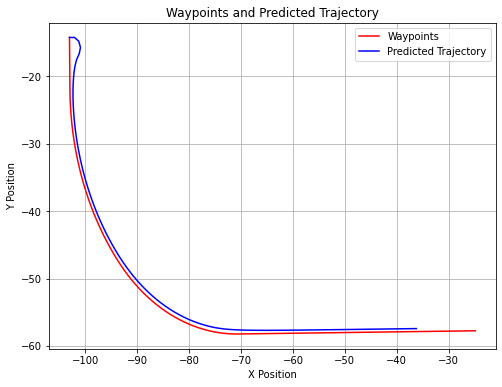

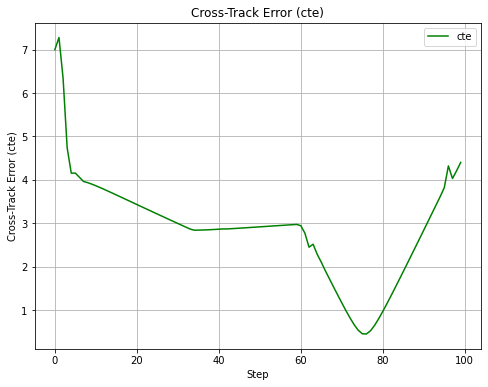

In [2]:
#---------------------------------- MPC----------------------------#
coeff_cte = 1
coeff_epsi = 1
coeff_acc = 0.5
coeff_steer = 0.5
def local_ahead(future_distance, dt, v, x, y, waypoint_pos,psi):
    # Calculate the next vehicle's position based on its velocity
    next_vehicle_x = x + v * np.cos(psi) * future_distance
    next_vehicle_y = y + v * np.sin(psi) * future_distance

    cte = np.sqrt((next_vehicle_x - waypoint_pos[0])**2 + (next_vehicle_y - waypoint_pos[1])**2)

    return cte
    
# Define the kinematic bicycle model function
def kinematic_bicycle_model(x, y, psi, v, throttle, steer, dt, LF):
    x += v * np.cos(psi) * dt
    y += v * np.sin(psi) * dt
    v = throttle * dt
    psi += (v / LF) * np.tan(steer) * dt
    return x, y, psi, v

# Define the cost function to minimize CTE
def cost_function(controls, *args):
    dt, LF, x, y, psi, v, waypoint = args
    throttle, steer = controls
    
    # Simulate the kinematic bicycle model with the given controls
    x, y, psi, v = kinematic_bicycle_model(x, y, psi, v, throttle, steer, dt, LF)
    # Calculate the CTE
    cte = local_ahead(10, dt, v, x, y, waypoint,psi)
    
    dx = x - waypoint[0]
    dy = y - waypoint[1]
    epsi = np.arctan2(dy, dx) - psi
    
    # Calculate the cost (to minimize CTE)
    cost = coeff_cte*cte**2 + epsi**2
    
    return cost

# Defining Constraints
# def eq_constraint(controls):
#     throttle, steer = controls
#     return [throttle + steer - 0.005]
    
def ineq_constraint_throttle(controls):
    throttle, steer = controls
    return [-1 - throttle, throttle - 1]
    
# def ineq_constraint_steer(controls):
#     throttle, steer = controls
#     return [-1 - steer, steer - 1]
    
# Load Waypoints from File
waypoints_file = 'waypoints.txt'
with open(waypoints_file, 'r') as file:
    lines = file.readlines()
waypoints = [tuple(map(float, line.strip().split(','))) for line in lines]

# Initial State
initial_state = (waypoints[0][0], waypoints[0][1], 0.2, 0.0)  # (x, y, psi, v)

# Simulation Parameters
dt = 1.4  # Time step
LF = 2.5  # Distance from front axle to the center of gravity
x, y, psi, v = initial_state

# Optimization Parameters
steer = 0.0
throttle = 0.5
cte_holder = []
predicted_trajectory = []
prev_cte = 0.0
cons = (
        {'type': 'ineq', 'fun': ineq_constraint_throttle},
       )
# Optimize control inputs (throttle and steer) to minimize CTE
for waypoint in waypoints:
    result = minimize(
        fun=cost_function,
        x0=[throttle, steer],
        args=(dt, LF, x, y, psi, v, waypoint),
        bounds=[(0, 1), (-1, 1)],  # Bounds for throttle and steer
        constraints={'type': 'ineq', 'fun': ineq_constraint_throttle},
        method='SLSQP',
        tol=1e-4,
        options={'maxiter': 200, 'disp': False},  
    )
    
    optimized_controls = result.x
    throttle, steer = optimized_controls
    # print("Optimized Controls: Throttle =", throttle, "Steer =", steer)
    
    # Simulate the kinematic bicycle model with optimized controls
    
    x, y, psi, v = kinematic_bicycle_model(x, y, psi, v, throttle, steer, dt, LF)
    cte = local_ahead(10, dt, v, x, y, waypoint,psi)
    predicted_trajectory.append((x, y))
    cte_holder.append(cte)
    
#---------------------------- Plot Waypoints and Predicted Trajectory ------------------------------
# Extract x and y coordinates for plotting
x_coords = [point[0] for point in waypoints]
y_coords = [point[1] for point in waypoints]
predicted_x = [point[0] for point in predicted_trajectory]
predicted_y = [point[1] for point in predicted_trajectory]
plt.figure(figsize=(8, 6))
plt.plot(x_coords, y_coords, 'r-', label='Waypoints')  
plt.plot(predicted_x, predicted_y, 'b-', label='Predicted Trajectory') 
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid()
plt.title('Waypoints and Predicted Trajectory')

# Create a new figure for plotting cte
plt.figure(figsize=(8, 6))
plt.plot( cte_holder, 'g-', label='cte')  # Green line for cte

plt.xlabel('Step')
plt.ylabel('Cross-Track Error (cte)')
plt.legend()
plt.grid()
plt.title('Cross-Track Error (cte)')

plt.show()